Epoch: 0 Error: 0.37424 Accuracy: 50.0%
Epoch: 100 Error: 0.32336 Accuracy: 50.0%
Epoch: 200 Error: 0.31985 Accuracy: 50.0%
Epoch: 300 Error: 0.31839 Accuracy: 25.0%
Epoch: 400 Error: 0.323 Accuracy: 50.0%
Epoch: 500 Error: 0.31449 Accuracy: 75.0%
Epoch: 600 Error: 0.24139 Accuracy: 75.0%
Epoch: 700 Error: 0.22356 Accuracy: 75.0%
Epoch: 800 Error: 0.22512 Accuracy: 75.0%
Epoch: 900 Error: 0.22464 Accuracy: 75.0%
Epoch: 1000 Error: 0.18497 Accuracy: 75.0%
Epoch: 1100 Error: 0.14277 Accuracy: 75.0%
Epoch: 1200 Error: 0.1449 Accuracy: 75.0%
Epoch: 1300 Error: 0.14527 Accuracy: 75.0%
Epoch: 1400 Error: 0.09884 Accuracy: 100.0%
Epoch: 1500 Error: 0.01523 Accuracy: 100.0%


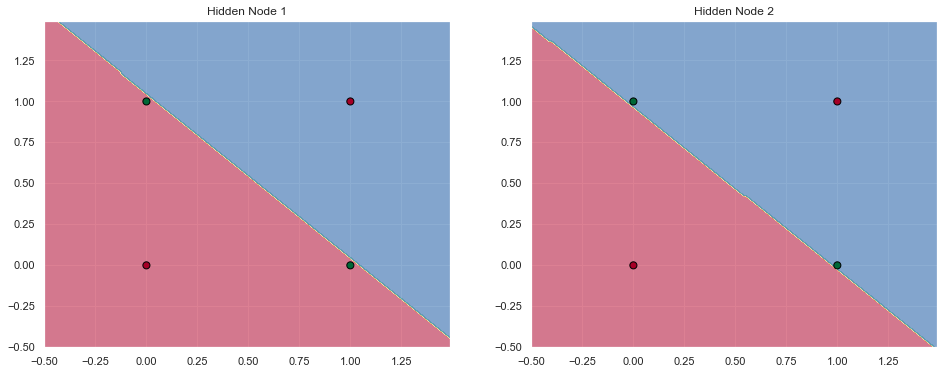

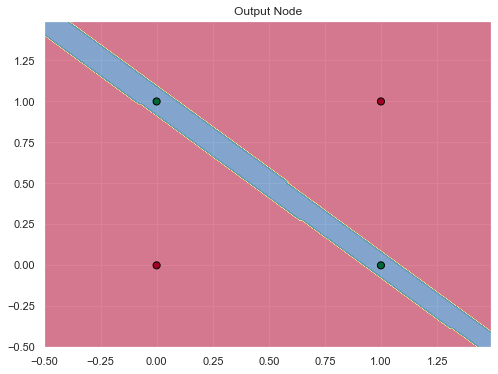

x1,x2,XOR,Hidden 1 (AND),Hidden 2 (OR),Output
0,0,0,0,0,0
0,1,1,0,1,1
1,0,1,0,1,1
1,1,0,1,1,0


In [194]:
import numpy as np
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
# Training data
train_x = np.array([[0, 0],
                   [0, 1],
                   [1, 0],
                   [1, 1]])

train_y = np.array([0, 1, 1, 0]) # XOR

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1 - x)


def train(inputs, desired_outputs, training_epochs, learning_rate):
    np.random.seed(3)
    # Set the weights to small random values in the range -0.5 to 0.5
    hidden1_w1 = np.random.uniform(-1, 1)
    hidden1_w2 = np.random.uniform(-1, 1)
    hidden1_bw = np.random.uniform(-1, 1)

    hidden2_w1 = np.random.uniform(-1, 1)
    hidden2_w2 = np.random.uniform(-1, 1)
    hidden2_bw = np.random.uniform(-1, 1)

    out_w1 = np.random.uniform(-1, 1)
    out_w2 = np.random.uniform(-1, 1)
    out_bw = np.random.uniform(-1, 1)
    
    # Each epoch will loop over the training data once
    for epoch in range(training_epochs + 1):
        epoch_error = []
        
        # Loop over all of the input examples
        for i in range(len(inputs)):
            
            # Calculate output
            hidden1_sum = (inputs[i][0] * hidden1_w1) + (inputs[i][1] * hidden1_w2) + hidden1_bw
            hidden1_output = sigmoid(hidden1_sum)
            
            hidden2_sum = (inputs[i][0] * hidden2_w1) + (inputs[i][1] * hidden2_w2) + hidden2_bw
            hidden2_output = sigmoid(hidden2_sum)  
            
            out_sum = (hidden1_output * out_w1) + (hidden2_output * out_w2) + out_bw
            output = sigmoid(out_sum)

            # Calculate error (desired output - actual output)
            error = desired_outputs[i] - output
            epoch_error.append(error) # Also keep track of total error for this epoch

            # Backprop
            out_delta = error * sigmoid_deriv(output)
            out_bias_delta = error

            # Calculate hidden layer errors (from the output layers weights and gradient)
            hidden1_error = out_delta * out_w1
            hidden2_error = out_delta * out_w2


            hidden1_w1_delta = hidden1_error * sigmoid_deriv(hidden1_output)
            hidden1_w2_delta = hidden1_error * sigmoid_deriv(hidden1_output)
            hidden1_bw_delta = hidden1_error

            hidden2_w1_delta = hidden2_error * sigmoid_deriv(hidden2_output)
            hidden2_w2_delta = hidden2_error * sigmoid_deriv(hidden2_output)
            hidden2_bw_delta = hidden2_error

            # Change in weight = learning rate * layers input * layers gradient
            out_w1 += learning_rate * hidden1_output * out_delta
            out_w2 += learning_rate * hidden2_output * out_delta
            out_bw += learning_rate * out_bias_delta

            hidden1_w1 += learning_rate * inputs[i][0] * hidden1_w1_delta
            hidden1_w2 += learning_rate * inputs[i][1] * hidden1_w2_delta
            hidden1_bw += learning_rate * hidden1_bw_delta

            hidden2_w1 += learning_rate * inputs[i][0] * hidden2_w1_delta
            hidden2_w2 += learning_rate * inputs[i][1] * hidden2_w2_delta
            hidden2_bw += learning_rate * hidden2_bw_delta
            
        if epoch % 100 == 0:
            # Calculate the mean squared error
            mean_error = np.square(epoch_error).mean() 
            
            # Count the number of correct predictions
            correct_predictions = 0
            for i in range(len(inputs)):
                hidden1_sum = (inputs[i][0] * hidden1_w1) + (inputs[i][1] * hidden1_w2) + hidden1_bw
                hidden1_output = sigmoid(hidden1_sum)

                hidden2_sum = (inputs[i][0] * hidden2_w1) + (inputs[i][1] * hidden2_w2) + hidden2_bw
                hidden2_output = sigmoid(hidden2_sum)  

                out_sum = (hidden1_output * out_w1) + (hidden2_output * out_w2) + out_bw
                output = 0 if out_sum < 0 else 1
                if output == desired_outputs[i]:
                    correct_predictions += 1
                    
            # Calculate the accuracy
            accuracy = (100/len(inputs)) * correct_predictions
            print("Epoch: " + str(epoch) + " Error: " + str(round(mean_error, 5)) + " Accuracy: " + str(accuracy) + "%")


    model = {'hidden1': [hidden1_w1, hidden1_w2, hidden1_bw],
             'hidden2': [hidden2_w1, hidden2_w2, hidden2_bw],
             'out': [out_w1, out_w2, out_bw]}
    return model
num_epochs = 1500
learning_rate = 1
trained_model = train(train_x, train_y, num_epochs, learning_rate)

def predict(x, model):
    """ Generates predictions for the whole network. """
    predictions = []
    
    # Loop over all of the input examples
    for i in range(len(x)):
        # Calculate output
        hidden1_sum = (x[i][0] * model['hidden1'][0]) + (x[i][1] * model['hidden1'][1]) + model['hidden1'][2]
        hidden1_output = sigmoid(hidden1_sum)

        hidden2_sum = (x[i][0] * model['hidden2'][0]) + (x[i][1] * model['hidden2'][1]) + model['hidden2'][2]
        hidden2_output = sigmoid(hidden2_sum)  

        out_sum = (hidden1_output * model['out'][0]) + (hidden2_output * model['out'][1]) + model['out'][2]
        # output = sigmoid(out_sum)
        output = 0 if out_sum < 0 else 1  # Using step function here to make graphs easier to read
        
        # Store predictions in an array
        predictions.append(output)
    return np.array(predictions)

def node_predict(x, node):
    """ Generates predictions for a single node. """
    predictions = []
    
    # Loop over all of the input examples
    for i in range(len(x)):
        # Calculate output
        weight_sum = (x[i][0] * node[0]) + (x[i][1] * node[1]) + node[2]
        # output = sigmoid(weight_sum)
        output = 0 if weight_sum < 0 else 1  # Using step function here to make graphs easier to read
        
        # Store predictions in an array
        predictions.append(output)
    return np.array(predictions)

def generate_decision_boundary(x, pred_func, model):
    """ Generates predictions for each point of a grid. """
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    z = pred_func(np.c_[xx.ravel(), yy.ravel()], model)
    z = z.reshape(xx.shape)
    return xx, yy, z

# generate_decision_boundary(train_x, predict, trained_model)
x_points, y_points, h1_pred = generate_decision_boundary(train_x, node_predict, trained_model['hidden1'])
_, _, h2_pred = generate_decision_boundary(train_x, node_predict, trained_model['hidden2'])
_, _, ann_pred = generate_decision_boundary(train_x, predict, trained_model)

figure, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].contourf(x_points, y_points, h1_pred, alpha = 0.6, cmap='Spectral')
ax[0].scatter(train_x[:, 0], train_x[:, 1], c=train_y.ravel(), s=50, cmap='RdYlGn', edgecolors='black')
ax[0].title.set_text('Hidden Node 1')
ax[1].contourf(x_points, y_points, h2_pred, alpha = 0.6, cmap='Spectral')
ax[1].scatter(train_x[:, 0], train_x[:, 1], c=train_y.ravel(), s=50, cmap='RdYlGn', edgecolors='black')
ax[1].title.set_text('Hidden Node 2')
plt.show()


plt.figure(figsize=(8, 6)) 
plt.contourf(x_points, y_points, ann_pred, alpha = 0.6, cmap='Spectral')
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y.ravel(), s=50, cmap='RdYlGn', edgecolors='black')
plt.title('Output Node')
plt.show()

from IPython.display import HTML, display
import pandas as pd

df = pd.DataFrame({'x1': train_x[:, 0], 'x2': train_x[:, 1], 'XOR': train_y,
                   'Hidden 1 (AND)': node_predict(train_x, trained_model['hidden1']),
                   'Hidden 2 (OR)': node_predict(train_x, trained_model['hidden2']),
                   'Output': predict(train_x, trained_model)})

display(HTML(df.to_html(index=False)))